In [31]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import sys
import re
import fileinput
from matplotlib.cm import get_cmap

temp_abund_data = []
temp_model_data = []
temp_grad_data = []
temp_test_data = []

y_param_list = []
y_param_names = []
oldstr = ['0-','1-','2-','3-','4-','5-','6-','7-','8-','9-']
newstr = ['0 -','1 -','2 -','3 -','4 -','5 -','6 -','7 -','8 -','9 -']
#,yn_y,y_range_start,y_range_end
"""
def plot_single_graph(fig,graph,xparam,xlabel,yparam,ylabel,plot_title,out_name,yn_x,x_range_start,x_range_end):
    fig, graph = plt.subplots()
    graph.plot(logP, yparam)
    graph.set_xlabel(xlabel)
    if yn_x:
        graph.set_xlim([x_range_start,x_range_end])
    graph.set_ylabel(ylabel)
    graph.set_title(plot_title)
    fig.savefig(out_name)
"""
# function to change file into space-separated float fields and parameterise the data using this new format
# line in 'with open' bit is type 'str'
"""def data_cleanup(f,temp_data):
    for line in f:
        for i in range(len(oldstr)):
            line = line.replace(oldstr[i],newstr[i])
        line = line.replace('   ',' ')
        line = line.replace('  ',' ')
        line = line.replace('D','E')
        match_ast = re.search('[**]', line)
        match_inf = re.search('Infinity',line)
        #print type(match)
        if match_ast or match_inf or (line.strip()==''):
            continue
        else:
            stam_data = np.array([float(parameter) for parameter in line.strip().split(' ')])
            #act_f_data = np.array(stam_f_data)
            temp_data.append(stam_data)"""

# create a function to get data in radiative layers of star (between core and convective envelope)
#core_ind = 0
#env_ind = 0
bound_inds = []

def data_read_CE(f):
    
    missed_line_inds = []
    temp_data = []
    temp_rad_zone_data = []
    check = 0
    match_lines = 0
    #number of lines to cut = number of line containing 'convective shell' label - (2 + any additional string lines)
    lines_cut = 0
    for line in f:
        for i in range(len(oldstr)):
            line = line.replace(oldstr[i],newstr[i])
        check = check + 1
        for x in range(4,1,-1):
            line = line.replace((x*' '),' ')
        line = line.replace('D','E')
        match_ast = re.search('[**]', line)
        match_inf = re.search('Infinity',line)
        match_core = re.search('CORE',line)
        match_env = re.search('INTERNO SHELL CONVETTIVA',line)
        if match_core or match_env:
            bound_inds.append(check)
            print 'boundary index = ',check
        elif match_ast or match_inf or (line.strip()==''):
            missed_line_inds.append(check)
            continue
        else:
            file_data = np.array([float(parameter) for parameter in line.strip().split(' ')])
            temp_data.append(file_data)
    out_all_data = np.array(temp_data)
    print 'Missed line indices: ',missed_line_inds
    
    if (f == model):
        for i in missed_line_inds:
            if (bound_inds[0] < i < bound_inds[-1]):
                lines_cut = lines_cut + 1
        print 'lines cut: ',lines_cut
        for j in range(len(out_all_data[:,-1])):
            if (j - (j-1) != 1):
                print j,j-1
            if (bound_inds[0] <= out_all_data[j,-1] <= (bound_inds[-1] - (lines_cut+2))):
                temp_rad_zone_data.append(out_all_data[j,:])
        out_rad_zone_data = np.array(temp_rad_zone_data)
    
        print 'Bounds: ',out_all_data[bound_inds[0],-1],out_all_data[bound_inds[-1],-1]
        print out_rad_zone_data.shape,', theoretical range: ',(bound_inds[-1]-bound_inds[0]-2)
    else:
        out_rad_zone_data = np.array(temp_rad_zone_data)
    
    print 'Total dataset: ',out_all_data.shape,'Last mesh point: ', out_all_data[-1,-1]
    return out_all_data,out_rad_zone_data
            

#def get_abund_params(param_list,dataset):

def data_focus(focus_parameter,focus_value,file_data):
    focus_data = []
    check = 0
    for i in range(len(focus_parameter)):
        if (focus_parameter[i] > focus_value):
            #print type(eps_nuclear[i])
            focus_data.append(file_data[i,:])
            check = check + 1
        else:
            continue
    print check
    return np.array(focus_data)

def focus_sync(first_file_focussed,second_file_data):
    second_file_focussed = []
    check = 0
    for i in range(len(second_file_data[:,0])):
        if (second_file_data[i,-1] in first_file_focussed[:,-1]):
            second_file_focussed.append(second_file_data[i,:])
            check = check + 1
        else:
            continue
    print check
    return np.array(second_file_focussed)

#with open ("mu_test_data/diff_mu_logL=2_7507_abund") as abund:
#    data_cleanup(abund,temp_abund_data)
with open ("mu_test_data/diff_mu_logL=2_7507_abund") as abund:
    print '\n    Reading abundances'
    abund_data,rad_zone_abund_data = data_read_CE(abund)
#print temp_abund_data
#abund_data = np.array(temp_abund_data)
#print abund_data.shape
#print abund_data

# sort '_abund' file data into parameters
mass_frac_ab = abund_data[:,0]
H = abund_data[:,1]
D = abund_data[:,2]
He3 = abund_data[:,3]
He4 = abund_data[:,4]
Li7 = abund_data[:,5]
Be7 = abund_data[:,6]
C12 = abund_data[:,7]
C13 = abund_data[:,8]
N14 = abund_data[:,9]
N15 = abund_data[:,10]
O16 = abund_data[:,11]
O17 = abund_data[:,12]
O18 = abund_data[:,13]
Fe56 = abund_data[:,14]
mesh_number_ab = abund_data[:,-1]

# array for ln(molecular mass)
#lnmu = np.log(mol_mass)
# correction for radius difference factor of 6.9599
#dXLi7_dr_correction = dXLi7_dr*6.9599
#print dXLi7_dr.shape,',',dXLi7_dr_correction.shape
#for i in range(20):
#    print dXLi7_dr[i],',',dXLi7_dr_correction[i]

#print mol_mass
#print lnmu


with open ("mu_test_data/diff_mu_logL=2_7507_model") as model:
    print '\n    Reading physical model'
    model_data,rad_zone_model_data = data_read_CE(model)
#print bound_inds,len(bound_inds),missed_line_inds,len(missed_line_inds)
print 'model data: ',model_data.shape, rad_zone_model_data.shape

    
#model_data = np.array(temp_model_data)

#model_data = model_data[:-1,:]
#print model_data
#print mass_frac

# sort '_model' file data
mass_frac_mod = model_data[:,0]
rad_frac = model_data[:,1]
logP = model_data[:,2]
logT = model_data[:,3]
logDensity = model_data[:,4]
L_Lsurface = model_data[:,5]
eps_nuclear = model_data[:,6]
eps_grav = model_data[:,7]
eps_neutrino = model_data[:,8]
delta = model_data[:,9]
radiat = model_data[:,10]
adiab = model_data[:,11]
sound_speed = model_data[:,12]
mesh_number_mod = model_data[:,-1]
#print type(logP)

#gradient file data
#with open ("mu_test_data/diff_mu_logL=2_7507_grads") as grads:
#    data_cleanup(grads,temp_grad_data)
with open ("mu_test_data/diff_mu_logL=2_7507_grads") as grads:
    print '\n    Reading gradients'
    grad_data,rad_zone_grads_data = data_read_CE(grads)    
#grad_data = np.array(temp_grad_data)

mass_frac_grad = grad_data[:,0]
mu = grad_data[:,1]
dmu_dr = grad_data[:,2]
dlnmu_dr = grad_data[:,3]
del_mu = grad_data[:,4]
dXLi7_dr = grad_data[:,5]
dXC12_dr = grad_data[:,6]
dXN14_dr = grad_data[:,7]
dXHe3_dr = grad_data[:,8]
dXHe4_dr = grad_data[:,9]
# thermohaline diffusion coefficient
D_therm = grad_data[:,10]
mesh_number_grad = grad_data[:,-1]

print abund_data.shape
print model_data.shape
print grad_data.shape

#print model_data [1,1]
print 'ln(mu) size = ', len(mass_frac_ab)
print 'ln(P) size = ', len(mass_frac_mod)
print 'grads size = ', len(mass_frac_grad)
#print type(logP)
#for i in range(len(dXLi7_dr_stam)):
#    print dXLi7_dr_stam[i]

nuc_burn_model_data = data_focus(eps_nuclear,1, model_data)
nuc_burn_abund_data = focus_sync(nuc_burn_model_data, abund_data)
nuc_burn_grads_data = focus_sync(nuc_burn_model_data, grad_data)


    Reading abundances
Missed line indices:  []
Total dataset:  (1552L, 16L) Last mesh point:  1552.0

    Reading physical model
boundary index =  354
boundary index =  940
Missed line indices:  [939, 1553]
lines cut:  1
Bounds:  355.0 941.0
(584L, 16L) , theoretical range:  584
Total dataset:  (1553L, 16L) Last mesh point:  1553.0
model data:  (1553L, 16L) (584L, 16L)

    Reading gradients
Missed line indices:  [1, 1552, 1553]
Total dataset:  (1550L, 13L) Last mesh point:  1551.0
(1552L, 16L)
(1553L, 16L)
(1550L, 13L)
ln(mu) size =  1552
ln(P) size =  1553
grads size =  1550
266
266
266


In [42]:
# define quantities for the nuclear burning region
# same quantities, but arrays are restricted to regions covered by 'nuc_burn_' arrays
nuc_rad_frac = nuc_burn_model_data[:,1]
nuc_logP = nuc_burn_model_data[:,2]
nuc_mesh_number_mod = nuc_burn_model_data[:,-1]

nuc_Li7 = nuc_burn_abund_data[:,5]
nuc_C12 = nuc_burn_abund_data[:,7]
nuc_N14 = nuc_burn_abund_data[:,9]

#nuc_mol_mass = nuc_burn_abund_data[:,15]
#lnmu_nuc = np.log(nuc_mol_mass)
#logmu_nuc = np.log10(nuc_mol_mass)
#nuc_lnmu_lnp = nuc_burn_abund_data[:,18]
#nuc_dXLi7_dr = nuc_burn_abund_data[:,19]
#nuc_dXC12_dr = nuc_burn_abund_data[:,20]
#nuc_dXN14_dr = nuc_burn_abund_data[:,21]
nuc_mesh_number_ab = nuc_burn_abund_data[:,-1]

#nuc_dXLi7_dr_correction = nuc_burn_abund_data[:,19]*6.9599
#nuc_dXC12_dr_correction = nuc_burn_abund_data[:,20]*6.9599
#nuc_dXN14_dr_correction = nuc_burn_abund_data[:,21]*6.9599
# radius in solar units = R/Ro in stampe (_header) file format = log of 'R' in 1st line
first_line_R = 5.70E+01
#rad_fraction_to_Rsun = (10**first_line_R)
#rad_fraction_to_metres = (10**first_line_R)*(6.957*(10**8))

# check cell continuity
#print y_param_names[0]

#print abund_data[-1,:]
#print model_data[-1,:]
#data_list=[]
#data_list_2=[]

print eps_nuclear #[i]
print nuc_burn_model_data.shape
print nuc_burn_abund_data.shape
print ((1 + nuc_mesh_number_mod[-1]) - nuc_mesh_number_mod[0])
print ((1 + nuc_mesh_number_ab[-1]) - nuc_mesh_number_ab[0])
#print nuc_burn_model_data[:,-1]
#print nuc_burn_abund_data[:,-1]
print 'diff loop start'
# check that both arrays cover the same layers of the star
for i in range(len(nuc_burn_model_data[:,-1])):
    diff = nuc_burn_model_data[i,-1] - nuc_burn_abund_data[i,-1]
    if diff != 0:
        print diff
print 'diff loop complete'

print first_line_R

nuc_data_list=[]
nuc_data_list_2=[]
#nuc_grad_list_2=[]
nuc_data_list_3=[]
"""
for i in range(1,len(Li7)-1):
    line_list = []
    j = i+1
    #print j
    dXLi7 = Li7[j] - Li7[i]
    dXC12 = C12[j] - C12[i]
    dXN14 = N14[j] - N14[i]
    drad = (rad_frac[j] - rad_frac[i])*22.1
    #print drad, mesh_number_ab[i]
    line_list = [dXLi7/drad, dXC12/drad, dXN14/drad, mesh_number_ab[i]]
    #data_list.append(line_list)
    if (mesh_number_ab[i] in nuc_burn_abund_data[:,-1]):
        nuc_data_list.append(line_list)
        #print mesh_number_ab[i]

for i in range(1,len(Li7)-1):
    line_list_2 = []
    h = i-1
    j = i+1
    #print j
    dXLi7 = Li7[j] - Li7[h]
    dXC12 = C12[j] - C12[h]
    dXN14 = N14[j] - N14[h]
    drad = (rad_frac[j] - rad_frac[h])*22.1
    check_rad = (rad_frac[j] - rad_frac[i])*22.1
    #print drad, check_rad, mesh_number_ab[i]
    line_list_2 = [dXLi7/drad, dXC12/drad, dXN14/drad, mesh_number_ab[i]]
    #grad_list_2 = [dXLi7_dr_stam[i], dXC12_dr_stam[i], dXN14_dr_stam[i], mesh_number_grad[i]]
    #print Li7[i],dXLi7,drad,dXLi7/drad,dXLi7_dr_stam[i-1]
    #data_list_2.append(line_list) and mesh_number_grad[i] in nuc_burn_abund_data[:,-1]
    if (mesh_number_ab[i] in nuc_burn_abund_data[:,-1] ):
        nuc_data_list_2.append(line_list_2)
        #nuc_grad_list_2.append(grad_list_2)
        #print mesh_number_ab[i], mesh_number_mod[i]

for i in range(1,len(Li7)-1):
    line_list_3 = []
    h = i-1
    #print j
    dXLi7 = Li7[i] - Li7[h]
    dXC12 = C12[i] - C12[h]
    dXN14 = N14[i] - N14[h]
    drad = (rad_frac[i] - rad_frac[h])*22.1
    #check_rad = (rad_frac[j] - rad_frac[i])*22.1
    #print drad, check_rad, mesh_number_ab[i]
    line_list_3 = [dXLi7/drad, dXC12/drad, dXN14/drad, mesh_number_ab[i]]
    #data_list_2.append(line_list)
    if (mesh_number_ab[i] in nuc_burn_abund_data[:,-1]):
        nuc_data_list_3.append(line_list_3)
        #print mesh_number_ab[i], mesh_number_mod[i]
        
     
nuc_stampe_data_arr = np.array(nuc_data_list)
nuc_stampe_data_arr_2 = np.array(nuc_data_list_2)
#nuc_stampe_grad_arr_2 = np.array(nuc_grad_list_2)
nuc_stampe_data_arr_3 = np.array(nuc_data_list_3)
# data_arr_2 = np.array(data_list_2)
#dXLi7_dr = dXLi7_dr[:-1]
print nuc_stampe_data_arr_2.shape"""
print dXLi7_dr.shape
print nuc_rad_frac.shape
#print 

#for i in range(1,len(nuc_stampe_data_arr[:,-1])):
#    print nuc_stampe_data_arr[i,0]/nuc_stampe_data_arr_2[i,0], nuc_stampe_data_arr[i,0]/nuc_stampe_data_arr_2[i-1,0], nuc_stampe_data_arr[i,-1]
"""avg_factor = 0
avg_counter = 0
for i in range(len(data_arr)):
    print i+1, Li7[i+1] - Li7[i],(rad_frac[i+1] - rad_frac[i])*15.9,data_arr[i],',',dXLi7_dr[i], ',', (data_arr[i]/dXLi7_dr[i])
    if (dXLi7_dr[i] != 0 and data_arr[i] != 0):
        avg_factor = avg_factor + (data_arr[i]/dXLi7_dr[i])
        avg_counter += 1
        
    
avg_factor = avg_factor/avg_counter
print 'Number of zero-less rows: ', avg_counter
print 'Average factor = ', avg_factor
print avg_factor/6.9599
Li_grad = data_arr[:,0]
C_grad = data_arr[:,1]
N_grad = data_arr[:,2]
print data_arr[0:3,:]"""

# check graph data
#for i in range(len(nuc_dXLi7_dr_correction)): 
 #   print nuc_rad_frac[i] , nuc_dXLi7_dr_correction[i]/rad_fraction_to_Rsun , nuc_dXC12_dr_correction[i]/rad_fraction_to_Rsun , nuc_dXN14_dr_correction[i]/rad_fraction_to_Rsun 
#print nuc_burn_abund_data

with open ("mu_test_data/2_7507_focus_abund","w") as f:
    for i in range(len(nuc_burn_abund_data[:,0])): 
        nuc_burn_abund_data[i,:].tofile(f," ")
        f.write('\n')
with open ("mu_test_data/2_7507_focus_model", 'w') as f:
    for i in range(len(nuc_burn_model_data[:,0])):
        nuc_burn_model_data[i,:].tofile(f," ")
        f.write('\n')
with open ("mu_test_data/2_7507_focus_grads","w") as f:
    for i in range(len(nuc_burn_abund_data[:,0])): 
        nuc_burn_grads_data[i,:].tofile(f," ")
        f.write('\n')

with open ("mu_test_data/2_7507_focus_rad_model","w") as f:
    for i in range(len(rad_zone_model_data[:,0])): 
        rad_zone_model_data[i,:].tofile(f," ")
        f.write('\n')

     

[  1.36700000e-06   1.35500000e-06   1.35500000e-06 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
(266L, 16L)
(266L, 16L)
266.0
266.0
diff loop start
diff loop complete
57.0
(1550L,)
(266L,)


minimum value of D_therm =  0.0


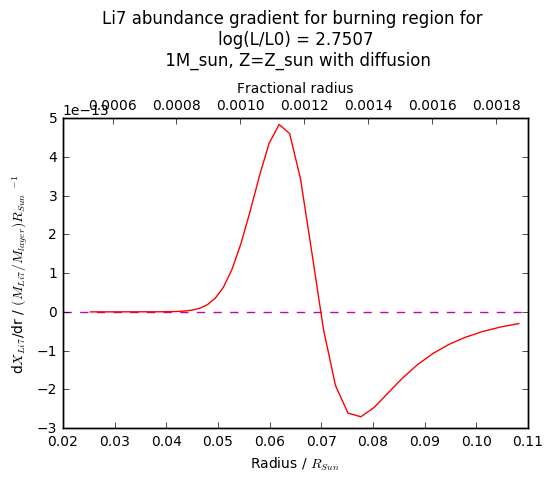

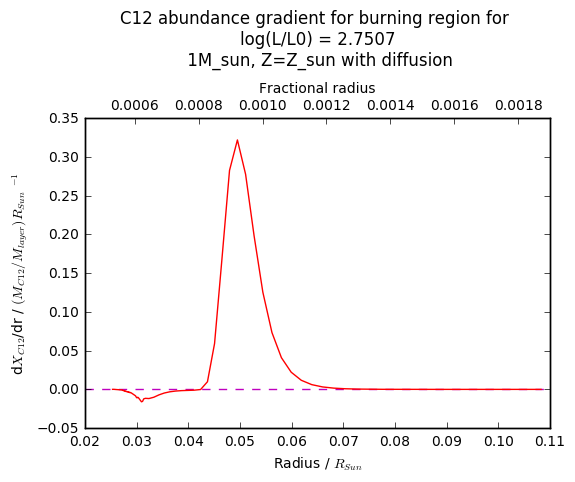

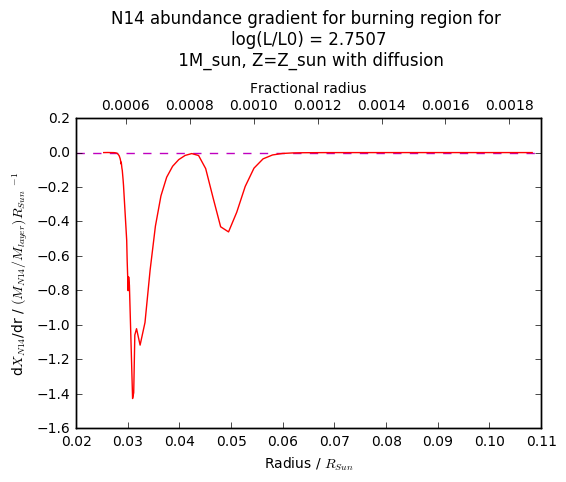

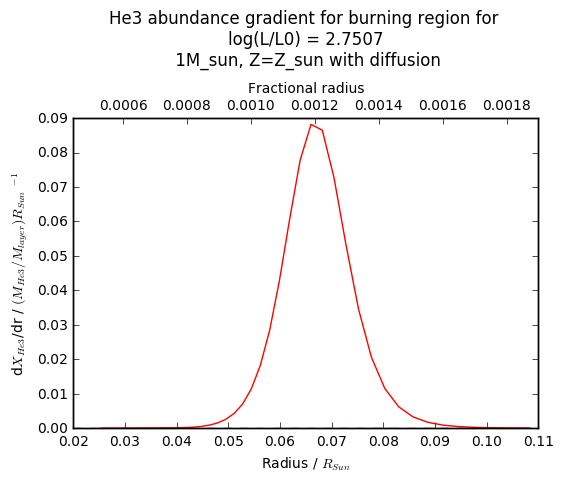

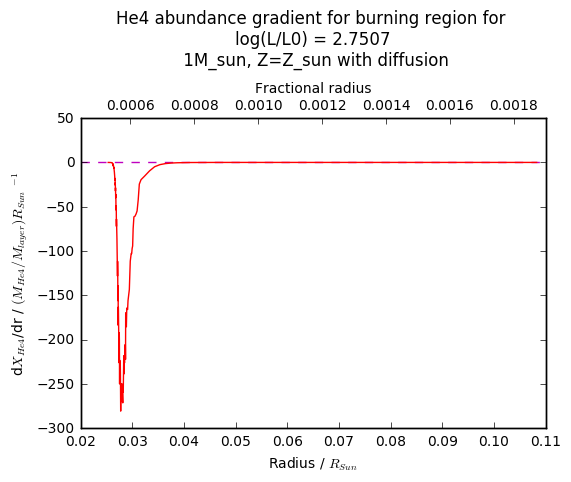

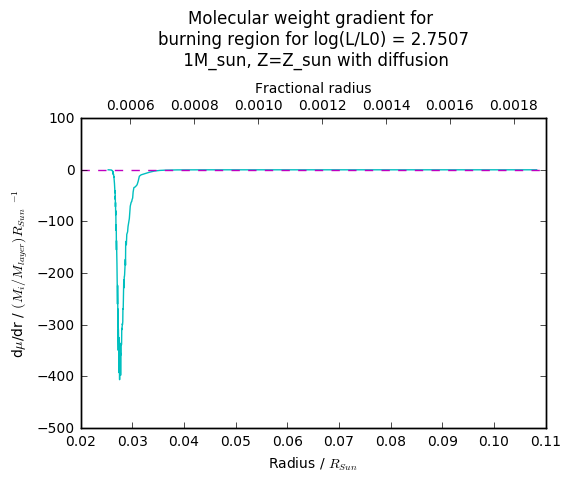

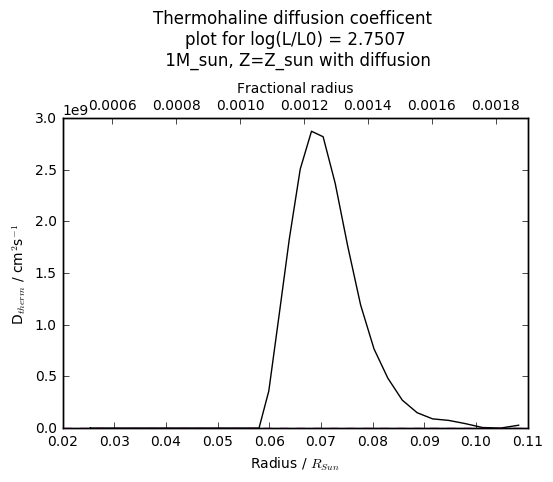

In [23]:
# Lithium-7 plot
fig, stam_graf0 = plt.subplots()
#stam_graf0.plot(nuc_burn_model_data[:,2], nuc_mol_mass, 'r')
stam_graf0.axhline(y=0.0, color='m', linestyle='--') #,label='no change in abundance'
stam_graf0.plot(nuc_rad_frac*(first_line_R), nuc_burn_grads_data[:,5], 'r')#, label='(k-1) to (k+1)'
stam_graf0.set_xlabel('Radius / $R_{Sun}$')
stam_graf0.set_ylabel('d$X_{Li7}$/dr / $(M_{Li7}/M_{layer}) R_{Sun}$ $^{-1}$')# d$X_{Li7}$/dr R_{Sun}$ $^{-1}
#plt.legend(loc='upper left', bbox_to_anchor=(0.55, 1.0))

#add fractional radius label to plot
frac_x = stam_graf0.twiny()
frac_x.set_xlim(nuc_rad_frac[0],nuc_rad_frac[-1])
frac_x.set_xlabel('Fractional radius')
#stam_graf0.set_ylim([-0.0003, 0.001])
#plt.show()
stam_graf0.set_title('Li7 abundance gradient for burning region for \nlog(L/L0) = 2.7507\n 1M_sun, Z=Z_sun with diffusion', y=1.15)
fig.savefig('mu_test_data/mu_test_graphs/burning_logL=2.7507_Li7_radius_gradient_19.pdf', bbox_inches='tight')



# Carbon-12 plot
fig, stam_graf0 = plt.subplots()
#stam_graf0.plot(nuc_burn_model_data[:,2], nuc_mol_mass, 'r')
stam_graf0.axhline(y=0.0, color='m', linestyle='--') #,label='no change in abundance'
stam_graf0.plot(nuc_rad_frac*(first_line_R), nuc_burn_grads_data[:,6], 'r')#, label='(k-1) to (k+1)'
stam_graf0.set_xlabel('Radius / $R_{Sun}$')
stam_graf0.set_ylabel('d$X_{C12}$/dr / $(M_{C12}/M_{layer}) R_{Sun}$ $^{-1}$')
#plt.legend(loc='upper left', bbox_to_anchor=(0.5, 0.6))
# nuc_dXLi7_dr_correction/rad_fraction_to_Rsun

#add fractional radius label to plot
frac_x = stam_graf0.twiny()
frac_x.set_xlim(nuc_rad_frac[0],nuc_rad_frac[-1])
frac_x.set_xlabel('Fractional radius')

#stam_graf0.set_xlim([0.03, 0.001])
#plt.show()
stam_graf0.set_title('C12 abundance gradient for burning region for \nlog(L/L0) = 2.7507\n 1M_sun, Z=Z_sun with diffusion', y=1.15)
fig.savefig('mu_test_data/mu_test_graphs/burning_logL=2.7507_C12_radius_gradient_19.pdf', bbox_inches='tight')

# Nitrogen-14 plot
fig, stam_graf0 = plt.subplots()
#stam_graf0.plot(nuc_burn_model_data[:,2], nuc_mol_mass, 'r')
stam_graf0.axhline(y=0.0, color='m', linestyle='--') #,label='no change in abundance'
# nuc_dXLi7_dr_correction/rad_fraction_to_Rsun
stam_graf0.plot(nuc_rad_frac*(first_line_R), nuc_burn_grads_data[:,7], 'r')#, label='(k-1) to (k+1)'
stam_graf0.set_xlabel('Radius / $R_{Sun}$')
stam_graf0.set_ylabel('d$X_{N14}$/dr / $(M_{N14}/M_{layer}) R_{Sun}$ $^{-1}$')
#plt.legend(loc='upper left', bbox_to_anchor=(0.5, 0.5))

#add fractional radius label to plot
frac_x = stam_graf0.twiny()
frac_x.set_xlim(nuc_rad_frac[0],nuc_rad_frac[-1])
frac_x.set_xlabel('Fractional radius')

#stam_graf0.set_ylim([-0.0003, 0.001])
#plt.show()
stam_graf0.set_title('N14 abundance gradient for burning region for \nlog(L/L0) = 2.7507\n 1M_sun, Z=Z_sun with diffusion', y=1.15)
fig.savefig('mu_test_data/mu_test_graphs/burning_logL=2.7507_N14_radius_gradient_19.pdf', bbox_inches='tight')

# Helium-3 plot
fig, stam_graf0 = plt.subplots()
#stam_graf0.plot(nuc_burn_model_data[:,2], nuc_mol_mass, 'r')
stam_graf0.axhline(y=0.0, color='m', linestyle='--') #,label='no change in abundance'
# nuc_dXLi7_dr_correction/rad_fraction_to_Rsun
stam_graf0.plot(nuc_rad_frac*(first_line_R), nuc_burn_grads_data[:,8], 'r')#, label='(k-1) to (k+1)'
stam_graf0.set_xlabel('Radius / $R_{Sun}$')
stam_graf0.set_ylabel('d$X_{He3}$/dr / $(M_{He3}/M_{layer}) R_{Sun}$ $^{-1}$')
#plt.legend(loc='upper left', bbox_to_anchor=(0.5, 0.5))

#add fractional radius label to plot
frac_x = stam_graf0.twiny()
frac_x.set_xlim(nuc_rad_frac[0],nuc_rad_frac[-1])
frac_x.set_xlabel('Fractional radius')

#stam_graf0.set_ylim([-0.0003, 0.001])
#plt.show()
stam_graf0.set_title('He3 abundance gradient for burning region for \nlog(L/L0) = 2.7507\n 1M_sun, Z=Z_sun with diffusion', y=1.15)
fig.savefig('mu_test_data/mu_test_graphs/burning_logL=2.7507_He3_radius_gradient_19.pdf', bbox_inches='tight')

# Helium-4 plot
fig, stam_graf0 = plt.subplots()
#stam_graf0.plot(nuc_burn_model_data[:,2], nuc_mol_mass, 'r')
stam_graf0.axhline(y=0.0, color='m', linestyle='--') #,label='no change in abundance'
# nuc_dXLi7_dr_correction/rad_fraction_to_Rsun
stam_graf0.plot(nuc_rad_frac*(first_line_R), nuc_burn_grads_data[:,9], 'r')#, label='(k-1) to (k+1)'
stam_graf0.set_xlabel('Radius / $R_{Sun}$')
stam_graf0.set_ylabel('d$X_{He4}$/dr / $(M_{He4}/M_{layer}) R_{Sun}$ $^{-1}$')
#plt.legend(loc='upper left', bbox_to_anchor=(0.5, 0.5))

#add fractional radius label to plot
frac_x = stam_graf0.twiny()
frac_x.set_xlim(nuc_rad_frac[0],nuc_rad_frac[-1])
frac_x.set_xlabel('Fractional radius')

#stam_graf0.set_ylim([-0.0003, 0.001])
#plt.show()
stam_graf0.set_title('He4 abundance gradient for burning region for \nlog(L/L0) = 2.7507\n 1M_sun, Z=Z_sun with diffusion', y=1.15)
fig.savefig('mu_test_data/mu_test_graphs/burning_logL=2.7507_He4_radius_gradient_19.pdf', bbox_inches='tight')

# molecular weight
fig, stam_graf0 = plt.subplots()
#stam_graf0.plot(logP[:-1], mol_mass, 'r')
stam_graf0.plot(nuc_rad_frac*(first_line_R), nuc_burn_grads_data[:,2], 'c')
stam_graf0.axhline(y=0.0, color='m', linestyle='--')
stam_graf0.set_xlabel('Radius / $R_{Sun}$')
stam_graf0.set_ylabel('d$\mu$/dr / $(M_{i}/M_{layer}) R_{Sun}$ $^{-1}$')

#add fractional radius label to plot
frac_x = stam_graf0.twiny()
frac_x.set_xlim(nuc_rad_frac[0],nuc_rad_frac[-1])
frac_x.set_xlabel('Fractional radius')
stam_graf0.set_title('Molecular weight gradient for \nburning region for log(L/L0) = 2.7507\n 1M_sun, Z=Z_sun with diffusion', y=1.15)
fig.savefig('mu_test_data/mu_test_graphs/burning_logL=2.7507_mu_grad.pdf', bbox_inches='tight')

# diffusion coefficients
fig, stam_graf0 = plt.subplots()
#stam_graf0.plot(logP[:-1], mol_mass, 'r')
stam_graf0.plot(nuc_rad_frac*(first_line_R), nuc_burn_grads_data[:,10], 'k')
stam_graf0.axhline(y=0.0, color='m', linestyle='--')
stam_graf0.set_xlabel('Radius / $R_{Sun}$')
stam_graf0.set_ylabel('D$_{therm}$ / cm$^{2}$s$^{-1}$')
#stam_graf0.set_ylim(min(nuc_burn_grads_data[:,10])-100000,max(nuc_burn_grads_data[:,10])+100000)

#add fractional radius label to plot
frac_x = stam_graf0.twiny()
frac_x.set_xlim(nuc_rad_frac[0],nuc_rad_frac[-1])
frac_x.set_xlabel('Fractional radius')
stam_graf0.set_title('Thermohaline diffusion coefficent \nplot for log(L/L0) = 2.7507\n 1M_sun, Z=Z_sun with diffusion', y=1.15)
fig.savefig('mu_test_data/mu_test_graphs/burning_logL=2.7507_coefficients_if.pdf', bbox_inches='tight')
print 'minimum value of D_therm = ',min(nuc_burn_grads_data[:,10])


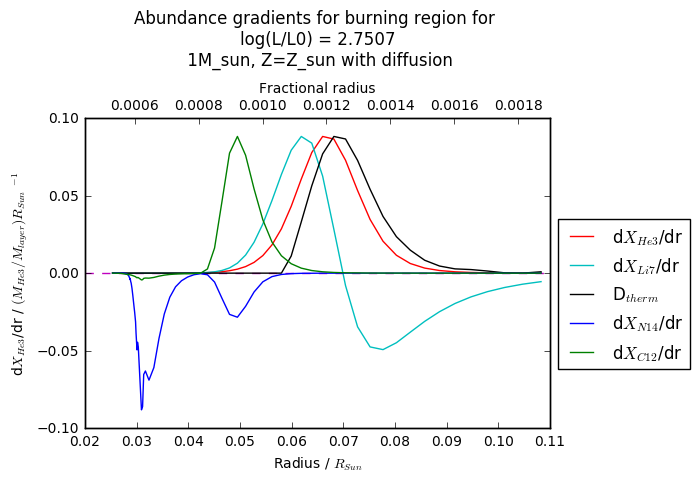

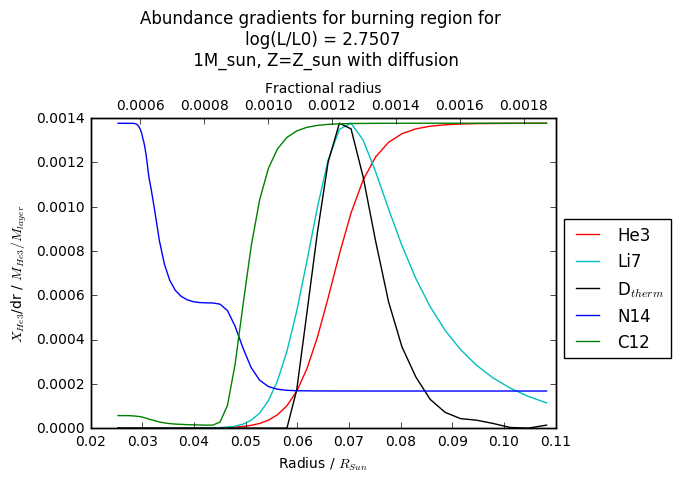

"\nfig, stam_graf0 = plt.subplots()\n#stam_graf0.plot(logP[:-1], mol_mass, 'r')\nstam_graf0.plot(logP, logT, 'k')\nstam_graf0.set_xlabel('log(P)')\nstam_graf0.set_ylabel('log(T$_{eff}$)')\nstam_graf0.set_title('temperature-pressure plot for \nlog(L/L0) = 2.7507\n 1M_sun, Z=Z_sun with diffusion')\nfig.savefig('mu_test_data/mu_test_graphs/logL=2.7507_logT_logP.pdf', bbox_inches='tight')\n"

In [26]:
# Multiple species and diffsuion coefficient plot
fig, stam_graf0 = plt.subplots()
#stam_graf0.plot(nuc_burn_model_data[:,2], nuc_mol_mass, 'r')
stam_graf0.axhline(y=0.0, color='m', linestyle='--') #,label='no change in abundance'
# scale curve data such that they fit onto the same axes while remaining visible
scale_factor_D = abs(max(nuc_burn_grads_data[:,10])/max(nuc_burn_grads_data[:,8]))
scale_factor_C = abs(max(nuc_burn_grads_data[:,6])/max(nuc_burn_grads_data[:,8]))
scale_factor_N = abs(min(nuc_burn_grads_data[:,7])/max(nuc_burn_grads_data[:,8]))
scale_factor_Li = abs(max(nuc_burn_grads_data[:,5])/max(nuc_burn_grads_data[:,8]))#x 10$^{11}$
stam_graf0.plot(nuc_rad_frac*(first_line_R), nuc_burn_grads_data[:,8],'r', label='d$X_{He3}$/dr')# He3
stam_graf0.plot(nuc_rad_frac*(first_line_R), nuc_burn_grads_data[:,5]/scale_factor_Li,'c', label='d$X_{Li7}$/dr')# Li7 
stam_graf0.plot(nuc_rad_frac*(first_line_R), nuc_burn_grads_data[:,10]/scale_factor_D, 'k', label='D$_{therm}$')# D_therm
stam_graf0.plot(nuc_rad_frac*(first_line_R), nuc_burn_grads_data[:,7]/scale_factor_N, 'b', label='d$X_{N14}$/dr')
stam_graf0.plot(nuc_rad_frac*(first_line_R), nuc_burn_grads_data[:,6]/scale_factor_C, 'g', label='d$X_{C12}$/dr')
stam_graf0.set_xlabel('Radius / $R_{Sun}$')
stam_graf0.set_ylabel('d$X_{He3}$/dr / $(M_{He3}/M_{layer}) R_{Sun}$ $^{-1}$')# d$X_{Li7}$/dr R_{Sun}$ $^{-1}
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.7))

#add fractional radius label to plot
frac_x = stam_graf0.twiny()
#d_therm = stam_graf0.twinx()
#d_therm.set_ylim(min(nuc_burn_grads_data[:,10])-100000,max(nuc_burn_grads_data[:,10])+100000)
frac_x.set_xlim(nuc_rad_frac[0],nuc_rad_frac[-1])
frac_x.set_xlabel('Fractional radius')
#d_therm.set_ylabel('D(thermohaline)')
stam_graf0.set_title('Abundance gradients for burning region for \nlog(L/L0) = 2.7507\n 1M_sun, Z=Z_sun with diffusion', y=1.15)

plt.show()
fig.savefig('mu_test_data/mu_test_graphs/burning_logL=2.7507_species_radius_gradient_Dtherm_if.pdf', bbox_inches='tight')

fig, stam_graf0 = plt.subplots()
# scale curve data such that they fit onto the same axes while remaining visible
scale_factor_D = abs(max(nuc_burn_grads_data[:,10])/max(nuc_burn_abund_data[:,3]))
scale_factor_C = abs(max(nuc_burn_abund_data[:,7])/max(nuc_burn_abund_data[:,3]))
scale_factor_N = abs(max(nuc_burn_abund_data[:,9])/max(nuc_burn_abund_data[:,3]))
scale_factor_Li = abs(max(nuc_burn_abund_data[:,5])/max(nuc_burn_abund_data[:,3]))#x 10$^{11}$
stam_graf0.plot(nuc_rad_frac*(first_line_R), nuc_burn_abund_data[:,3],'r', label='He3')# He3
stam_graf0.plot(nuc_rad_frac*(first_line_R), nuc_burn_abund_data[:,5]/scale_factor_Li,'c', label='Li7')# Li7 
stam_graf0.plot(nuc_rad_frac*(first_line_R), nuc_burn_grads_data[:,10]/scale_factor_D, 'k', label='D$_{therm}$')# D_therm
stam_graf0.plot(nuc_rad_frac*(first_line_R), nuc_burn_abund_data[:,9]/scale_factor_N, 'b', label='N14')
stam_graf0.plot(nuc_rad_frac*(first_line_R), nuc_burn_abund_data[:,7]/scale_factor_C, 'g', label='C12')
stam_graf0.set_xlabel('Radius / $R_{Sun}$')
stam_graf0.set_ylabel('$X_{He3}$/dr / $M_{He3}/M_{layer}$')# d$X_{Li7}$/dr R_{Sun}$ $^{-1}
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.7))

#add fractional radius label to plot
frac_x = stam_graf0.twiny()
#d_therm = stam_graf0.twinx()
#d_therm.set_ylim(min(nuc_burn_grads_data[:,10])-100000,max(nuc_burn_grads_data[:,10])+100000)
frac_x.set_xlim(nuc_rad_frac[0],nuc_rad_frac[-1])
frac_x.set_xlabel('Fractional radius')
#d_therm.set_ylabel('D(thermohaline)')
stam_graf0.set_title('Abundance gradients for burning region for \nlog(L/L0) = 2.7507\n 1M_sun, Z=Z_sun with diffusion', y=1.15)

plt.show()
fig.savefig('mu_test_data/mu_test_graphs/burning_logL=2.7507_species_Dtherm_if.pdf', bbox_inches='tight')

"""
fig, stam_graf0 = plt.subplots()
#stam_graf0.plot(logP[:-1], mol_mass, 'r')
stam_graf0.plot(logP, logT, 'k')
stam_graf0.set_xlabel('log(P)')
stam_graf0.set_ylabel('log(T$_{eff}$)')
stam_graf0.set_title('temperature-pressure plot for \nlog(L/L0) = 2.7507\n 1M_sun, Z=Z_sun with diffusion')
fig.savefig('mu_test_data/mu_test_graphs/logL=2.7507_logT_logP.pdf', bbox_inches='tight')
"""

584
584
(584L, 16L)
(584L, 13L)
[354, 940]


"\n# dln(mu)/dln(P) plot\nfig, stam_graf0 = plt.subplots()\n#stam_graf0.plot(nuc_burn_model_data[:,2], nuc_mol_mass, 'r')\nstam_graf0.axhline(y=0.0, color='m', linestyle='--') #,label='no change in abundance'\n# nuc_dXLi7_dr_correction/rad_fraction_to_Rsun\nstam_graf0.plot(rad_zone_model_data[:,1]*(first_line_R), rad_zone_grads_data[:,4], 'r')#, label='(k-1) to (k+1)'\nstam_graf0.set_xlabel('Radius / $R_{Sun}$')\nstam_graf0.set_ylabel(r'$\nabla_{\\mu}$')\n#plt.legend(loc='upper left', bbox_to_anchor=(0.5, 0.5))\n\n#add fractional radius label to plot\nfrac_x = stam_graf0.twiny()\nfrac_x.set_xlim(rad_zone_model_data[0,1],rad_zone_model_data[-1,1])\nfrac_x.set_xlabel('Fractional radius')\n\nstam_graf0.set_ylim([-1e-06, 1e-06])\n#plt.show()\nstam_graf0.set_title('dln(mu)/dln(P) for radiative zone for \nlog(L/L0) = 2.7507\n 1M_sun, Z=Z_sun with diffusion', y=1.15)\nfig.savefig('mu_test_data/mu_test_graphs/rad_logL=2.7507_nabla_mu_focus.pdf', bbox_inches='tight')\n\n# dln(mu)/dln(P) plot\nf

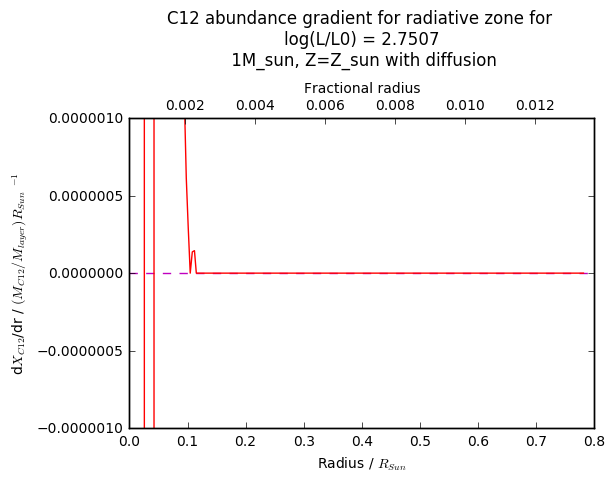

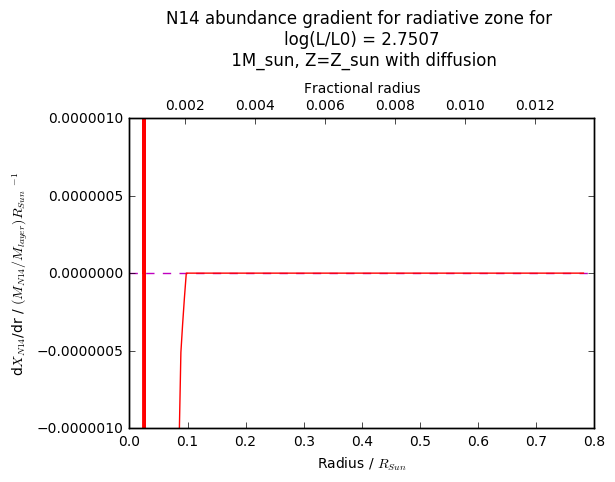

In [56]:
# Radiation zone plots

rad_zone_abund_data = focus_sync(rad_zone_model_data, abund_data)
rad_zone_grads_data = focus_sync(rad_zone_model_data, grad_data)
print rad_zone_abund_data.shape
print rad_zone_grads_data.shape
print bound_inds

with open ("mu_test_data/2_7507_rad_stuff","w") as f:
    for i in range(len(rad_zone_model_data[:,0])): 
        rad_zone_model_data[i,1].tofile(f," "),f.write(' '),rad_zone_grads_data[i,6].tofile(f," "),f.write(' '),rad_zone_grads_data[i,7].tofile(f," "),f.write(' '),rad_zone_grads_data[i,4].tofile(f," ")
        f.write('\n')
""""""
# Carbon-12 plot
fig, stam_graf0 = plt.subplots()
#stam_graf0.plot(nuc_burn_model_data[:,2], nuc_mol_mass, 'r')
stam_graf0.axhline(y=0.0, color='m', linestyle='--') #,label='no change in abundance'
stam_graf0.plot(rad_zone_model_data[:,1]*(first_line_R), rad_zone_grads_data[:,6], 'r')#, label='(k-1) to (k+1)'
stam_graf0.set_xlabel('Radius / $R_{Sun}$')
stam_graf0.set_ylabel('d$X_{C12}$/dr / $(M_{C12}/M_{layer}) R_{Sun}$ $^{-1}$')
#plt.legend(loc='upper left', bbox_to_anchor=(0.5, 0.6))
# nuc_dXLi7_dr_correction/rad_fraction_to_Rsun

#add fractional radius label to plot
frac_x = stam_graf0.twiny()
frac_x.set_xlim(rad_zone_model_data[0,1],rad_zone_model_data[-1,1])
frac_x.set_xlabel('Fractional radius')

stam_graf0.set_ylim([-1e-06, 1e-06])
#plt.show()
stam_graf0.set_title('C12 abundance gradient for radiative zone for \nlog(L/L0) = 2.7507\n 1M_sun, Z=Z_sun with diffusion', y=1.15)
fig.savefig('mu_test_data/mu_test_graphs/rad_logL=2.7507_C12_radius_gradient_focus.pdf', bbox_inches='tight')

# Nitrogen-14 plot
fig, stam_graf0 = plt.subplots()
#stam_graf0.plot(nuc_burn_model_data[:,2], nuc_mol_mass, 'r')
stam_graf0.axhline(y=0.0, color='m', linestyle='--') #,label='no change in abundance'
# nuc_dXLi7_dr_correction/rad_fraction_to_Rsun
stam_graf0.plot(rad_zone_model_data[:,1]*(first_line_R),rad_zone_grads_data[:,7], 'r')#, label='(k-1) to (k+1)'
stam_graf0.set_xlabel('Radius / $R_{Sun}$')
stam_graf0.set_ylabel('d$X_{N14}$/dr / $(M_{N14}/M_{layer}) R_{Sun}$ $^{-1}$')
#plt.legend(loc='upper left', bbox_to_anchor=(0.5, 0.5))

#add fractional radius label to plot
frac_x = stam_graf0.twiny()
frac_x.set_xlim(rad_zone_model_data[0,1],rad_zone_model_data[-1,1])
frac_x.set_xlabel('Fractional radius')

stam_graf0.set_ylim([-1e-06, 1e-06])
#plt.show()
stam_graf0.set_title('N14 abundance gradient for radiative zone for \nlog(L/L0) = 2.7507\n 1M_sun, Z=Z_sun with diffusion', y=1.15)
fig.savefig('mu_test_data/mu_test_graphs/rad_logL=2.7507_N14_radius_gradient_focus.pdf', bbox_inches='tight')

"""
# dln(mu)/dln(P) plot
fig, stam_graf0 = plt.subplots()
#stam_graf0.plot(nuc_burn_model_data[:,2], nuc_mol_mass, 'r')
stam_graf0.axhline(y=0.0, color='m', linestyle='--') #,label='no change in abundance'
# nuc_dXLi7_dr_correction/rad_fraction_to_Rsun
stam_graf0.plot(rad_zone_model_data[:,1]*(first_line_R), rad_zone_grads_data[:,4], 'r')#, label='(k-1) to (k+1)'
stam_graf0.set_xlabel('Radius / $R_{Sun}$')
stam_graf0.set_ylabel(r'$\nabla_{\mu}$')
#plt.legend(loc='upper left', bbox_to_anchor=(0.5, 0.5))

#add fractional radius label to plot
frac_x = stam_graf0.twiny()
frac_x.set_xlim(rad_zone_model_data[0,1],rad_zone_model_data[-1,1])
frac_x.set_xlabel('Fractional radius')

stam_graf0.set_ylim([-1e-06, 1e-06])
#plt.show()
stam_graf0.set_title('dln(mu)/dln(P) for radiative zone for \nlog(L/L0) = 2.7507\n 1M_sun, Z=Z_sun with diffusion', y=1.15)
fig.savefig('mu_test_data/mu_test_graphs/rad_logL=2.7507_nabla_mu_focus.pdf', bbox_inches='tight')

# dln(mu)/dln(P) plot
fig, stam_graf0 = plt.subplots()
#stam_graf0.plot(nuc_burn_model_data[:,2], nuc_mol_mass, 'r')
stam_graf0.axhline(y=0.0, color='m', linestyle='--') #,label='no change in abundance'
# nuc_dXLi7_dr_correction/rad_fraction_to_Rsun
stam_graf0.plot(rad_zone_model_data[:,1]*(first_line_R), rad_zone_grads_data[:,4], 'r')#, label='(k-1) to (k+1)'
stam_graf0.set_xlabel('Radius / $R_{Sun}$')
stam_graf0.set_ylabel(r'$\nabla_{\mu}$')
#plt.legend(loc='upper left', bbox_to_anchor=(0.5, 0.5))

#add fractional radius label to plot
frac_x = stam_graf0.twiny()
frac_x.set_xlim(rad_zone_model_data[0,1],rad_zone_model_data[-1,1])
frac_x.set_xlabel('Fractional radius')

#stam_graf0.set_ylim([-1e-04, 1e-04])
#plt.show()
stam_graf0.set_title('dln(mu)/dln(P) for radiative zone for \nlog(L/L0) = 2.7507\n 1M_sun, Z=Z_sun with diffusion', y=1.15)
fig.savefig('mu_test_data/mu_test_graphs/rad_logL=2.7507_nabla_mu.pdf', bbox_inches='tight')"""

In [22]:
temp_model_21 = []
temp_model_25 = []
temp_model_27 = []
temp_grads_21 = []
temp_grads_25 = []
temp_grads_27 = []

with open ("mu_test_data/diff_mu_logL=2_1231_model") as model_21:
    data_cleanup(model_21,temp_model_21)
with open ("mu_test_data/diff_mu_logL=2_5001_model") as model_25:
    data_cleanup(model_25,temp_model_25)
with open ("mu_test_data/diff_mu_logL=2_7507_model") as model_27:
    data_cleanup(model_27,temp_model_27)
model_data_21 = np.array(temp_model_21)
model_data_25 = np.array(temp_model_25)
model_data_27 = np.array(temp_model_27)

with open ("mu_test_data/diff_mu_logL=2_1231_grads") as grads_21:
    data_cleanup(grads_21,temp_grads_21)
with open ("mu_test_data/diff_mu_logL=2_5001_grads") as grads_25:
    data_cleanup(grads_25,temp_grads_25)
with open ("mu_test_data/diff_mu_logL=2_7507_grads") as grads_27:
    data_cleanup(grads_27,temp_grads_27)
grads_data_21 = np.array(temp_grads_21)
grads_data_25 = np.array(temp_grads_25)
grads_data_27 = np.array(temp_grads_27)

focus_model_21 = focus_sync(grads_data_21,model_data_21)
focus_model_25 = focus_sync(grads_data_25,model_data_25)
focus_model_27 = focus_sync(grads_data_27,model_data_27)

del_mu_21 = grads_data_21[:,4]
del_mu_25 = grads_data_25[:,4]
del_mu_27 = grads_data_27[:,4]

rad_ad_21 = focus_model_21[:,10] - focus_model_21[:,11]
rad_ad_25 = focus_model_25[:,10] - focus_model_25[:,11]
rad_ad_27 = focus_model_27[:,10] - focus_model_27[:,11]

D_21 = grads_data_21[:,-2]
D_25 = grads_data_25[:,-2]
D_27 = grads_data_27[:,-2]

rad_frac_21 = focus_model_21[:,1]
rad_frac_25 = focus_model_25[:,1]
rad_frac_27 = focus_model_27[:,1]

mass_frac_21 = grads_data_21[:,0]
mass_frac_25 = grads_data_25[:,0]
mass_frac_27 = grads_data_27[:,0]

logP_21 = focus_model_21[:,2]
logP_25 = focus_model_25[:,2]
logP_27 = focus_model_27[:,2]

logT_21 = focus_model_21[:,3]
logT_25 = focus_model_25[:,3]
logT_27 = focus_model_27[:,3]

logDens_21 = focus_model_21[:,4]
logDens_25 = focus_model_25[:,4]
logDens_27 = focus_model_27[:,4]

opac_21 = focus_model_21[:,12]
opac_25 = focus_model_25[:,12]
opac_27 = focus_model_27[:,12]

mu_21 = grads_data_21[:,1]
mu_25 = grads_data_25[:,1]
mu_27 = grads_data_27[:,1]

model_degen_21 = data_focus(mu_21,0.134e1, model_data_21)
model_degen_25 = data_focus(mu_25,0.134e1, model_data_25)
model_degen_27 = data_focus(mu_27,0.134e1, model_data_27)

1421
1454
1550
527
577
672


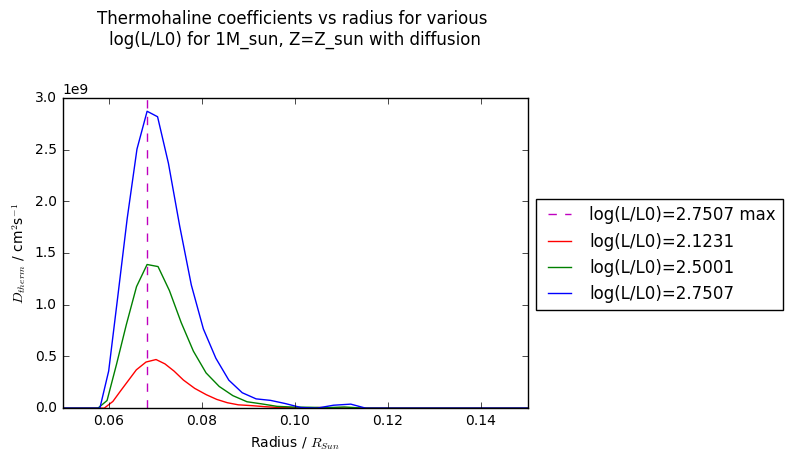

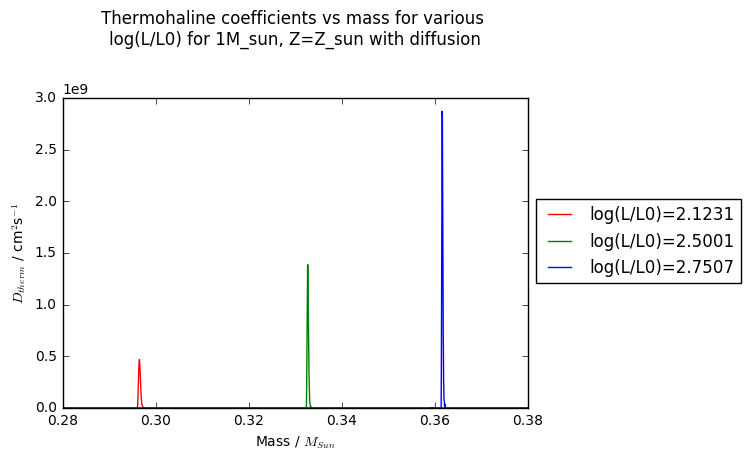

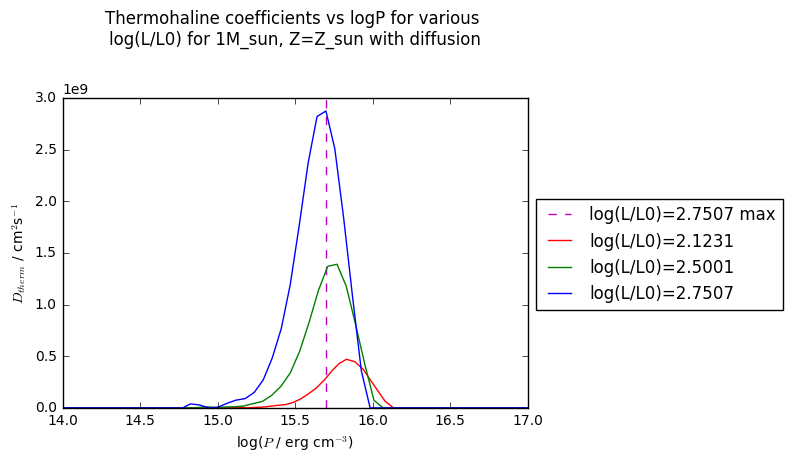

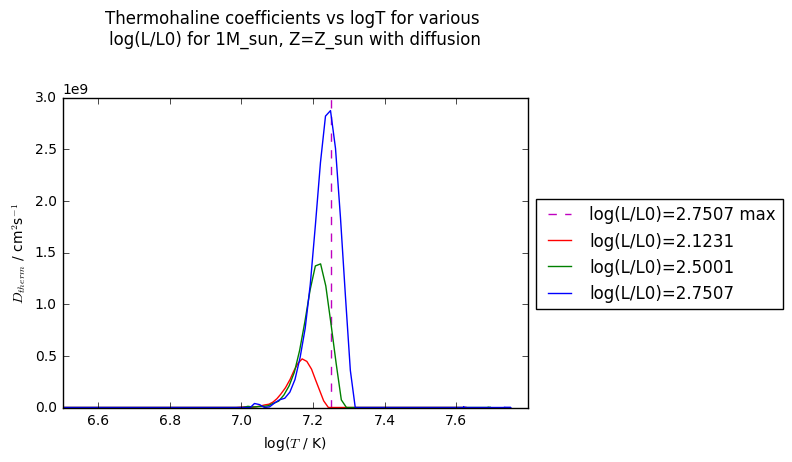

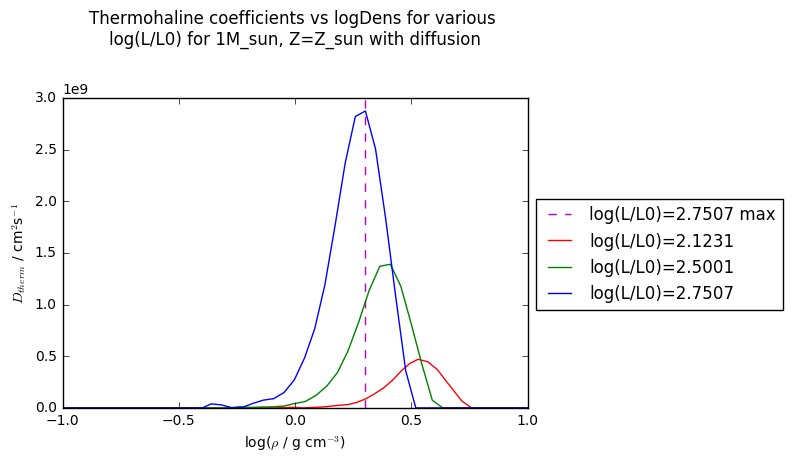

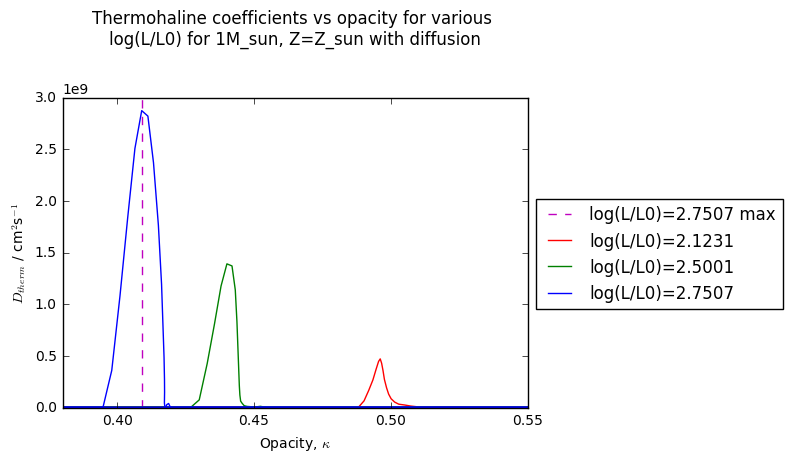

In [23]:
fig, stam_graf0 = plt.subplots()
stam_graf0.axvline(x=rad_frac_27[np.argmax(D_27)]*(5.70E+01), color='m', linestyle='--',label='log(L/L0)=2.7507 max')
stam_graf0.plot(rad_frac_21*(2.21E+01), D_21,'r', label='log(L/L0)=2.1231')
stam_graf0.plot(rad_frac_25*(3.88E+01), D_25,'g', label='log(L/L0)=2.5001')
stam_graf0.plot(rad_frac_27*(5.70E+01), D_27, 'b', label='log(L/L0)=2.7507')
stam_graf0.set_xlabel('Radius / $R_{Sun}$')
stam_graf0.set_ylabel('$D_{therm}$ / cm$^{2}$s$^{-1}$')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.7))
stam_graf0.set_xlim(0.05,0.15)
stam_graf0.set_title('Thermohaline coefficients vs radius for various \nlog(L/L0) for 1M_sun, Z=Z_sun with diffusion', y=1.15)
plt.show()
fig.savefig('mu_test_data/mu_test_graphs/logL=various_radius_Dtherm.pdf', bbox_inches='tight')

fig, stam_graf0 = plt.subplots()
#stam_graf0.axvline(x=mass_frac_27[np.argmax(D_27)], color='m', linestyle='--',label='log(L/L0)=2.7507 max')
stam_graf0.plot(mass_frac_21, D_21,'r', label='log(L/L0)=2.1231')
stam_graf0.plot(mass_frac_25, D_25,'g', label='log(L/L0)=2.5001')
stam_graf0.plot(mass_frac_27, D_27, 'b', label='log(L/L0)=2.7507')
stam_graf0.set_xlabel('Mass / $M_{Sun}$')
stam_graf0.set_ylabel('$D_{therm}$ / cm$^{2}$s$^{-1}$')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.7))
stam_graf0.set_xlim(0.28,0.38)
stam_graf0.set_title('Thermohaline coefficients vs mass for various \nlog(L/L0) for 1M_sun, Z=Z_sun with diffusion', y=1.15)
plt.show()
fig.savefig('mu_test_data/mu_test_graphs/logL=various_mass_Dtherm.pdf', bbox_inches='tight')

fig, stam_graf0 = plt.subplots()
stam_graf0.axvline(x=logP_27[np.argmax(D_27)], color='m', linestyle='--',label='log(L/L0)=2.7507 max')
stam_graf0.plot(logP_21, D_21,'r', label='log(L/L0)=2.1231')
stam_graf0.plot(logP_25, D_25,'g', label='log(L/L0)=2.5001')
stam_graf0.plot(logP_27, D_27, 'b', label='log(L/L0)=2.7507')
stam_graf0.set_xlabel('log($P$ / erg cm$^{-3}$)')
stam_graf0.set_ylabel('$D_{therm}$ / cm$^{2}$s$^{-1}$')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.7))
stam_graf0.set_xlim(14,17)
stam_graf0.set_title('Thermohaline coefficients vs logP for various \nlog(L/L0) for 1M_sun, Z=Z_sun with diffusion', y=1.15)
plt.show()
fig.savefig('mu_test_data/mu_test_graphs/logL=various_logP_Dtherm.pdf', bbox_inches='tight')

fig, stam_graf0 = plt.subplots()
stam_graf0.axvline(x=logT_27[np.argmax(D_27)], color='m', linestyle='--',label='log(L/L0)=2.7507 max')
stam_graf0.plot(logT_21, D_21,'r', label='log(L/L0)=2.1231')
stam_graf0.plot(logT_25, D_25,'g', label='log(L/L0)=2.5001')
stam_graf0.plot(logT_27, D_27, 'b', label='log(L/L0)=2.7507')
stam_graf0.set_xlabel('log($T$ / K)')
stam_graf0.set_ylabel('$D_{therm}$ / cm$^{2}$s$^{-1}$')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.7))
stam_graf0.set_xlim(6.5,7.8)
stam_graf0.set_title('Thermohaline coefficients vs logT for various \nlog(L/L0) for 1M_sun, Z=Z_sun with diffusion', y=1.15)
plt.show()
fig.savefig('mu_test_data/mu_test_graphs/logL=various_logT_Dtherm.pdf', bbox_inches='tight')

fig, stam_graf0 = plt.subplots()
stam_graf0.axvline(x=logDens_27[np.argmax(D_27)], color='m', linestyle='--',label='log(L/L0)=2.7507 max')
stam_graf0.plot(logDens_21, D_21,'r', label='log(L/L0)=2.1231')
stam_graf0.plot(logDens_25, D_25,'g', label='log(L/L0)=2.5001')
stam_graf0.plot(logDens_27, D_27, 'b', label='log(L/L0)=2.7507')
stam_graf0.set_xlabel(r'log($\rho$ / g cm$^{-3}$)')
stam_graf0.set_ylabel('$D_{therm}$ / cm$^{2}$s$^{-1}$')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.7))
stam_graf0.set_xlim(-1,1)
stam_graf0.set_title('Thermohaline coefficients vs logDens for various \nlog(L/L0) for 1M_sun, Z=Z_sun with diffusion', y=1.15)
plt.show()
fig.savefig('mu_test_data/mu_test_graphs/logL=various_logDens_Dtherm.pdf', bbox_inches='tight')

fig, stam_graf0 = plt.subplots()
stam_graf0.axvline(x=opac_27[np.argmax(D_27)], color='m', linestyle='--',label='log(L/L0)=2.7507 max')
stam_graf0.plot(opac_21, D_21,'r', label='log(L/L0)=2.1231')
stam_graf0.plot(opac_25, D_25,'g', label='log(L/L0)=2.5001')
stam_graf0.plot(opac_27, D_27, 'b', label='log(L/L0)=2.7507')
stam_graf0.set_xlabel(r'Opacity, $\kappa$')
stam_graf0.set_ylabel('$D_{therm}$ / cm$^{2}$s$^{-1}$')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.7))
stam_graf0.set_xlim(0.38,0.55)
stam_graf0.set_title('Thermohaline coefficients vs opacity for various \nlog(L/L0) for 1M_sun, Z=Z_sun with diffusion', y=1.15)
plt.show()
fig.savefig('mu_test_data/mu_test_graphs/logL=various_opac_Dtherm.pdf', bbox_inches='tight')

C:\Users\User\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':
C:\Users\User\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app
C:\Users\User\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()
C:\Users\User\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in divide


1.54430769231 0.99003003003 1.66666666667


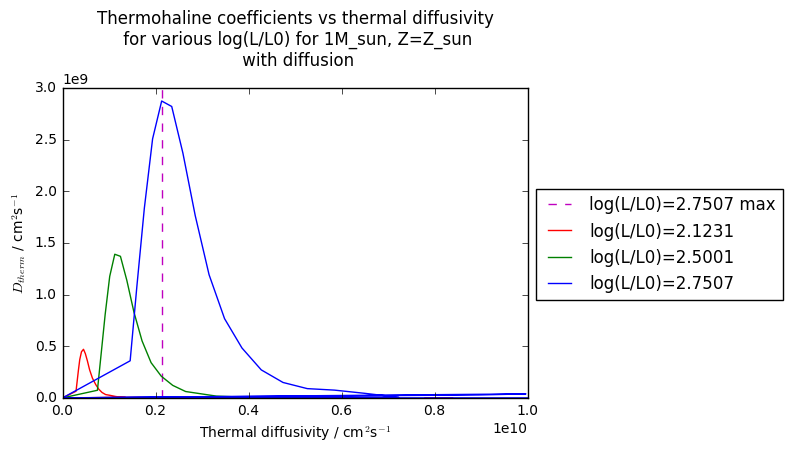

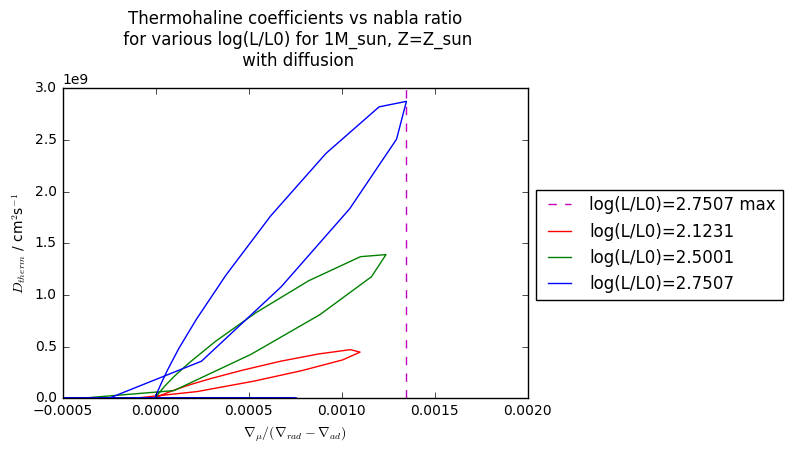

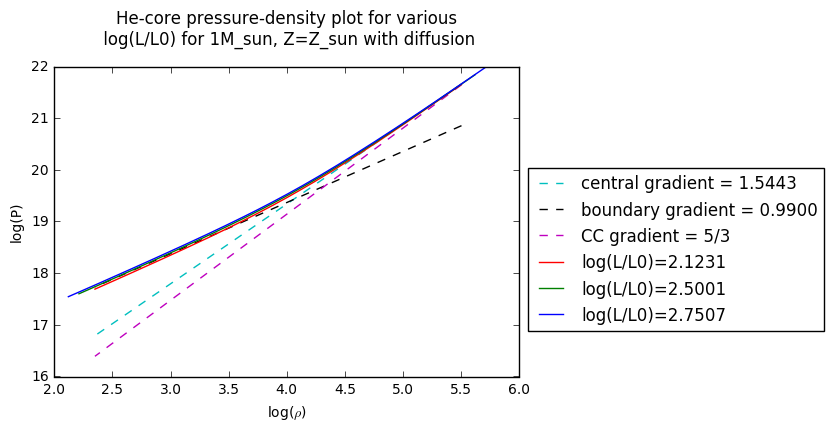

In [24]:
K_therm_21 = (D_21*rad_ad_21)/(1000*del_mu_21)
K_therm_25 = (D_25*rad_ad_25)/(1000*del_mu_25)
K_therm_27 = (D_27*rad_ad_27)/(1000*del_mu_27)

del_ratio_21 = del_mu_21/rad_ad_21
del_ratio_25 = del_mu_25/rad_ad_25
del_ratio_27 = del_mu_27/rad_ad_27

logP_degen_21 = model_degen_21[:,2]
logP_degen_25 = model_degen_25[:,2]
logP_degen_27 = model_degen_27[:,2]

logDens_degen_21 = model_degen_21[:,4]
logDens_degen_25 = model_degen_25[:,4]
logDens_degen_27 = model_degen_27[:,4]

test_grad = (3.0e9)/(-3.0e10)

# for P = k*(rho^(5/3)):
# logP = (5/3)*log(rho) + log(k)
#-> log(k) = (logP_0)-((5/3)*log(rho_0))
av_logP_degen_C = (logP_degen_21[0] + logP_degen_25[0] + logP_degen_27[0])/(3.0)
av_logDens_degen_C = (logDens_degen_21[0] + logDens_degen_25[0] + logDens_degen_27[0])/(3.0)
av_logP_degen_edge = (logP_degen_21[-1] + logP_degen_25[-1] + logP_degen_27[-1])/(3.0)
av_logDens_degen_edge = (logDens_degen_21[-1] + logDens_degen_25[-1] + logDens_degen_27[-1])/(3.0)
dens_P_intercept = av_logP_degen_C-((5.0/3.0)*av_logDens_degen_C)

#dens_P_intercept_edge = logP_degen_21[-1]-((5/3)*logDens_degen_21[-1])
central_grad_21 = (logP_degen_21[0] - logP_degen_21[10])/(logDens_degen_21[0] - logDens_degen_21[10])
degen_edge_grad_21 = (logP_degen_21[-11] - logP_degen_21[-1])/(logDens_degen_21[-11] - logDens_degen_21[-1])
boundary_intercept = av_logP_degen_edge-(degen_edge_grad_21*av_logDens_degen_edge)
central_intercept = av_logP_degen_C-(central_grad_21*av_logDens_degen_C)
print central_grad_21, degen_edge_grad_21,(5.0/3.0)

fig, stam_graf0 = plt.subplots()
stam_graf0.axvline(x=K_therm_27[np.argmax(D_27)], color='m', linestyle='--',label='log(L/L0)=2.7507 max')
stam_graf0.plot(K_therm_21, D_21,'r', label='log(L/L0)=2.1231')
stam_graf0.plot(K_therm_25, D_25,'g', label='log(L/L0)=2.5001')
stam_graf0.plot(K_therm_27, D_27, 'b', label='log(L/L0)=2.7507')
stam_graf0.set_xlabel('Thermal diffusivity / cm$^{2}$s$^{-1}$')
stam_graf0.set_ylabel('$D_{therm}$ / cm$^{2}$s$^{-1}$')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.7))
stam_graf0.set_xlim(0,1e10)
stam_graf0.set_title('Thermohaline coefficients vs thermal diffusivity\n for various log(L/L0) for 1M_sun, Z=Z_sun\n with diffusion', y=1.05)
plt.show()
fig.savefig('mu_test_data/mu_test_graphs/logL=various_therm_diff_Dtherm.pdf', bbox_inches='tight')

fig, stam_graf0 = plt.subplots()
stam_graf0.axvline(x=del_ratio_27[np.argmax(D_27)], color='m', linestyle='--',label='log(L/L0)=2.7507 max')
stam_graf0.plot(del_ratio_21, D_21,'r', label='log(L/L0)=2.1231')
stam_graf0.plot(del_ratio_25, D_25,'g', label='log(L/L0)=2.5001')
stam_graf0.plot(del_ratio_27, D_27, 'b', label='log(L/L0)=2.7507')
stam_graf0.set_xlabel(r'$\nabla_{\mu}/(\nabla_{rad} - \nabla_{ad})$')
stam_graf0.set_ylabel('$D_{therm}$ / cm$^{2}$s$^{-1}$')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.7))
stam_graf0.set_xlim(-0.0005,0.002)
stam_graf0.set_title('Thermohaline coefficients vs nabla ratio\n for various log(L/L0) for 1M_sun, Z=Z_sun\n with diffusion', y=1.05)
plt.show()
fig.savefig('mu_test_data/mu_test_graphs/logL=various_nabla_ratio_Dtherm.pdf', bbox_inches='tight')

fig, stam_graf0 = plt.subplots() #central_grad_21, degen_edge_grad_21
stam_graf0.plot(logDens_degen_21,(logDens_degen_21*central_grad_21 + central_intercept),color='c', linestyle='--',label='central gradient = 1.5443')
stam_graf0.plot(logDens_degen_21,(logDens_degen_21*degen_edge_grad_21 + boundary_intercept),color='k', linestyle='--',label='boundary gradient = 0.9900')
stam_graf0.plot(logDens_degen_21,(logDens_degen_21*(5.0/3.0) + dens_P_intercept),color='m', linestyle='--',label='CC gradient = 5/3')
stam_graf0.plot(logDens_degen_21, logP_degen_21,'r', label='log(L/L0)=2.1231')
stam_graf0.plot(logDens_degen_25, logP_degen_25,'g', label='log(L/L0)=2.5001')
stam_graf0.plot(logDens_degen_27, logP_degen_27, 'b', label='log(L/L0)=2.7507')
stam_graf0.set_xlabel(r'log($\rho$)')
stam_graf0.set_ylabel('log(P)')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.7))
#stam_graf0.set_xlim(-0.0005,0.002)
stam_graf0.set_title('He-core pressure-density plot for various\n log(L/L0) for 1M_sun, Z=Z_sun with diffusion', y=1.05)
plt.show()
fig.savefig('mu_test_data/mu_test_graphs/logL=various_core logP_logDens.pdf', bbox_inches='tight')

In [19]:
#sanity check
X_frac_arr = []
for j in range(len(mass_frac_ab)):
    X_layer_j = 0
    for i in range(14):
        # check the data
        # print i , 'mass fraction = ', abund_data[0,i+1]
        X_layer_j = X_layer_j + abund_data[j,i+1]
    
        
    X_frac_arr.append(X_layer_j)
        
print 'size of _abund columns: ', len(mass_frac_ab)
max_frac = max(X_frac_arr)
min_frac = min(X_frac_arr)
av_frac = sum(X_frac_arr)/len(mass_frac_ab)
#print abund_data[0,:]
print 'Fraction of shell mass in shell (should = 1) = ', av_frac
print 'Maximum shell fractional mass: shell ', X_frac_arr.index(max_frac), ' with value of ', max_frac
print 'Minimum shell fractional mass: shell ', X_frac_arr.index(min_frac), ' with value of ', min_frac
X_dev_arr = []
for k in X_frac_arr:
    X_dev_arr.append(k - 1)
print X_frac_arr[0], ' - 1 = ',X_dev_arr[0]

size of _abund columns:  1487
Fraction of shell mass in shell (should = 1) =  0.999603742452
Maximum shell fractional mass: shell  695  with value of  1.004563111
Minimum shell fractional mass: shell  595  with value of  0.991116791308
0.99313982  - 1 =  -0.00686018


12
12


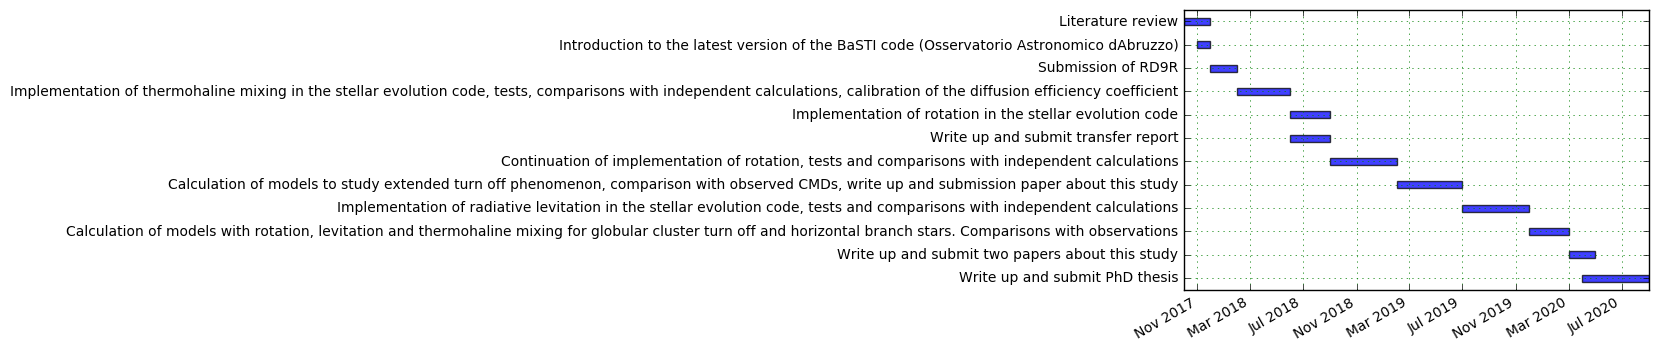

In [69]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
#import matplotlib.font_manager as font_manager
import matplotlib.dates as mdat

def make_date(month,year):
    date = dt.datetime(int(year), int(month), 1)
    out_date = mdat.date2num(date)
    return out_date

task_labels = []
task_labels.append('Literature review')
task_labels.append('Introduction to the latest version of the BaSTI code (Osservatorio Astronomico d''Abruzzo)')
task_labels.append('Submission of RD9R')
task_labels.append('Implementation of thermohaline mixing in the stellar evolution code, tests, comparisons with independent calculations, calibration of the diffusion efficiency coefficient')
task_labels.append('Implementation of rotation in the stellar evolution code')
task_labels.append('Write up and submit transfer report')
task_labels.append('Continuation of implementation of rotation, tests and comparisons with independent calculations')
task_labels.append('Calculation of models to study extended turn off phenomenon, comparison with observed CMDs, write up and submission paper about this study')
task_labels.append('Implementation of radiative levitation in the stellar evolution code, tests and comparisons with independent calculations')
task_labels.append('Calculation of models with rotation, levitation and thermohaline mixing for globular cluster turn off and horizontal branch stars. Comparisons with observations')
task_labels.append('Write up and submit two papers about this study')
task_labels.append('Write up and submit PhD thesis')
#Visit to Osservatorio Astronomico d''Abruzzo to be i

task_dates = []
task_dates.append([make_date(10,2017),make_date(12,2017)])
task_dates.append([make_date(11,2017),make_date(12,2017)])
task_dates.append([make_date(12,2017),make_date(2,2018)])
task_dates.append([make_date(2,2018),make_date(6,2018)])
task_dates.append([make_date(6,2018),make_date(9,2018)])
task_dates.append([make_date(6,2018),make_date(9,2018)])
task_dates.append([make_date(9,2018),make_date(2,2019)])
task_dates.append([make_date(2,2019),make_date(7,2019)])
task_dates.append([make_date(7,2019),make_date(12,2019)])
task_dates.append([make_date(12,2019),make_date(3,2020)])
task_dates.append([make_date(3,2020),make_date(5,2020)])
task_dates.append([make_date(4,2020),make_date(9,2020)])

print len(task_labels)
print len(task_dates)

plot_dates = {}
for i,j in enumerate(task_labels):
    plot_dates[j] = task_dates[i]
    
fig, ax = plt.subplots()
#ax = fig.add_subplot(111)

for i in range(len(task_labels)):
    start_date,end_date = plot_dates[task_labels[i]]
    ax.barh(i+1, end_date - start_date, left=start_date, height=0.3, align='center', color='blue',alpha = 0.75)
pos = np.arange(1,len(task_labels)+1,1)
locsy, labelsy = plt.yticks(pos,task_labels)
plt.setp(labelsy, fontsize = 10)

ax.axis('tight')
ax.set_ylim(ymin = 0.5, ymax = 12.5)
ax.grid(color = 'g', linestyle = ':')
 
ax.xaxis_date() #Tell matplotlib that these are dates...
 
rule = mdat.rrulewrapper(mdat.MONTHLY, interval=1)
loc = mdat.RRuleLocator(rule)
formatter = mdat.DateFormatter("%b '%y")
ax.invert_yaxis()
fig.autofmt_xdate()